In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
sb.set() # set the default Seaborn style for graphics
seed = 134

# Abstract  

# Data-Driven Approach To Understanding Product Reviews
### Motivation
As data analysts, we have been hired by Brazilian XYZ company. 

Over the past year, the Brazilian XYZ online shopping website has grown. Now that Brazilian XYZ online shopping website has cultivated a large following in both business owners as well as customers, it is important to be selective on which bussinesses it wants to promote on its mainpage. 


### Problem Statement
The main goal of our project is to select bussiness to promote on the front page of the website. In other to do this we estimating the performance of each company. 

***

# Importing Our Data

In [2]:
# Import Data
# leads dataset
mql = pd.read_csv('ecomm_data/olist_marketing_qualified_leads_dataset.csv')
cd = pd.read_csv('ecomm_data/olist_closed_deals_dataset.csv')
# sellers dataset
sellers = pd.read_csv('ecomm_data/olist_sellers_dataset.csv')
# order items dataset
items = pd.read_csv('ecomm_data/olist_order_items_dataset.csv')
# review data set
review_df = pd.read_csv('ecomm_data/olist_order_reviews_dataset.csv')
# order status data set
order_status_df = pd.read_csv('ecomm_data/olist_orders_dataset.csv')
# product describtion dataset
prod_desc_df = pd.read_csv('ecomm_data/olist_products_dataset.csv')
#customer dataset
cust = pd.read_csv('ecomm_data/olist_customers_dataset.csv')


# Merge Data
# marketing funnel dataset (NaNs are leads that did not close a deal)
mf = mql.merge(cd, on='mql_id', how='left')
# marketing funnel merged with sellers (this way you get seller location)
mf_sellers = sellers.merge(mf, on='seller_id', how='left')
# marketing funnel merged with items (this way you get products sold by sellers)
mf_items = mf_sellers.merge(items, on='seller_id', how='left')
# merge reviews
mf_df = mf_items.merge(review_df, on='order_id', how='left')
# merge order status
mf_df = order_status_df.merge(mf_df,on='order_id', how='left')
# merge customer info
mf_df = cust.merge(mf_df,on='customer_id', how='left')



In [3]:
mf_df.dtypes

customer_id                       object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
seller_id                         object
seller_zip_code_prefix           float64
seller_city                       object
seller_state                      object
mql_id                            object
first_contact_date                object
landing_page_id                   object
origin                            object
sdr_id                            object
sr_id                             object
won_date                          object
business_segment                  object
lead_type       

___

### Selecting Indicators
Possible Performance Indicators:
* Review Score
> High review score implies happy customers
* Sales 
> High sales implies that these sellers are popular and brining traffic to the website
* Review Comments
> Analysis of review comments can tell how happy a customer is



## Exploratory Analysis: #1 Review Score

It is obvious that high review scores implies that costumers are happy. In this portion we shall see explore if usage of review score is feasible.

From our dataframe the possible useful candidates are:

* `order_id`
* `customer_id` (?)
* `customer_unique_id` (?)
* `seller_id`
* `review_score`

### Q1. Why are there 2 customer's id columns? Which one is useful to us?

In [4]:
customer_df = mf_df[['customer_id','customer_unique_id']]
customer_df.describe()

,customer_id,customer_unique_id
count,114097,114097
unique,99441,96096
top,be1c4e52bb71e0c54b11a26b8e8d59f2,d97b3cfb22b0d6b25ac9ed4e9c2d481b
freq,22,24


Observations:
* There are `customer_id` and `customer_unique_id` non-null as observed when data was imported
* Notice that customer_id has a higher unique count than custoemer_unique_id

Let's try to compare this to order_id

In [5]:
mf_df['order_id'].describe()                

count                               114097
unique                               99441
top       5a3b1c29a49756e75f1ef513383c0c12
freq                                    22
Name: order_id, dtype: object

Observations:
* Unique count of `order_id` is 99441
* Unique count of `customer_id` is 99441
* `customer_id` is only unique to the specific `order_id`
* `customer_unique_id` is the global indentifier throughout this dataset
* Hence, `customer_unique_id` should be used 

## Caulculating Average Review Score

In [6]:
customer_df = mf_df[['customer_unique_id','review_score','seller_id','order_id']]
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114097 entries, 0 to 114096
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_unique_id  114097 non-null  object 
 1   review_score        113322 non-null  float64
 2   seller_id           113322 non-null  object 
 3   order_id            114097 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.4+ MB


In [7]:
seller_df = sellers
seller_df.set_index('seller_id',inplace=True)
seller_df['avg_review_score'] = 0
seller_df['review_score_total'] = 0
seller_df['review_count'] = 0

In [8]:
for index, row in customer_df.iterrows():
    if pd.notna(row['seller_id']):
        seller_df.loc[row['seller_id'],'review_score_total'] += row['review_score']
        seller_df.loc[row['seller_id'],'review_count'] += 1
        seller_df.loc[row['seller_id'],'avg_review_score'] = seller_df.loc[row['seller_id'],'review_score_total']/seller_df.loc[row['seller_id'],'review_count']

### Q2. Should sellers with low review score counts be counted?
No, due to small sample size, we shall not be accounting for bussinesses with low review scores.

### Q3. How much is considered a good sample size?
Reference: https://files.eric.ed.gov/fulltext/EJ919871.pdf


According to a reasearch paper done on sampling issues, it is recommended to have more than 20 samples.

In [9]:
#Clean data
seller_df_20 = seller_df[seller_df['review_score_total'] >= 20]

In [10]:
seller_df_20['avg_review_score'].describe()

count    1838.000000
mean        4.113033
std         0.519389
min         1.250000
25%         3.857143
50%         4.166667
75%         4.443910
max         5.000000
Name: avg_review_score, dtype: float64

<AxesSubplot:xlabel='avg_review_score', ylabel='Count'>

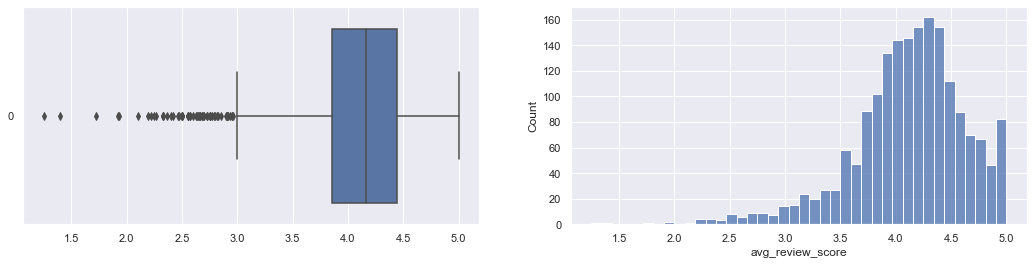

In [11]:
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_df_20['avg_review_score'], orient = "h", ax = axes[0])
sb.histplot(data = seller_df_20['avg_review_score'], ax = axes[1])

<AxesSubplot:xlabel='avg_review_score'>

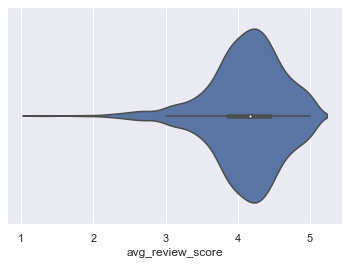

In [12]:
sb.violinplot(data = seller_df_20, x = 'avg_review_score')

In [13]:
seller_df_above4 = seller_df[seller_df['avg_review_score'] >= 4.5]

In [14]:
seller_df_above4['avg_review_score'].describe()

count    970.000000
mean       4.829881
std        0.196726
min        4.500000
25%        4.652924
50%        5.000000
75%        5.000000
max        5.000000
Name: avg_review_score, dtype: float64

<AxesSubplot:xlabel='avg_review_score', ylabel='Count'>

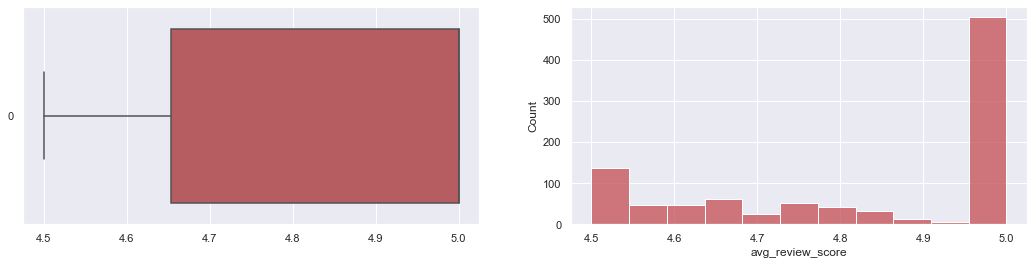

In [15]:
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = seller_df_above4['avg_review_score'], orient = "h", ax = axes[0], color = 'r')
sb.histplot(data = seller_df_above4['avg_review_score'], ax = axes[1], color = 'r')

<AxesSubplot:xlabel='avg_review_score'>

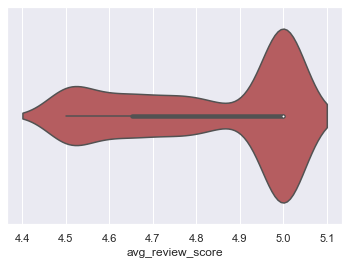

In [16]:
sb.violinplot(data = seller_df_above4, x = 'avg_review_score', color = 'r')

In [17]:
seller_df_above4 = seller_df_above4.sort_values(by=['avg_review_score'],ascending=False)
seller_df_above4[['avg_review_score']].head()

,avg_review_score
seller_id,
59bbc819b99a733f02f0d6b49d1c253d,5.0
a9ae440659f48b7849df83e82734150b,5.0
2c00c85d30361cd2ced2969cffbbffa3,5.0
615c3462099ffa940d37b17dfda19594,5.0
4fae87d32467e18eb46e4a76a0a0b9ce,5.0


In [18]:
seller_df_above4[['avg_review_score']].describe()

,avg_review_score
count,970.000000
mean,4.829881
std,0.196726
min,4.500000
25%,4.652924
50%,5.000000
75%,5.000000
max,5.000000


Observations:
* There are no outliers >3.0 avg ratings
* there at >80 stores that have score of 5

The main page can't promote all 80 stores at a time. Could there be a indicator that can distinguish the stores even more?

## Exploratory Analysis: #2 Sales

Maybe we can use rank the companies performance by sales?

From our dataset the possible useful columns are:
* `order_id`
* `customer_unique_id`
* `seller_id`
* `price`

In [19]:
customer_df = mf_df[['customer_unique_id','review_score','seller_id','price']]
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114097 entries, 0 to 114096
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_unique_id  114097 non-null  object 
 1   review_score        113322 non-null  float64
 2   seller_id           113322 non-null  object 
 3   price               113322 non-null  float64
dtypes: float64(2), object(2)
memory usage: 4.4+ MB


In [20]:
seller_df_ = sellers
seller_df['t_sale'] = 0
seller_df['t_sale_count'] = 0
seller_df['avg_sale'] = 0

In [21]:
for index, row in customer_df.iterrows():
    if pd.notna(row['price']):
        seller_df.loc[row['seller_id'],'t_sale'] += row['price']
        seller_df.loc[row['seller_id'],'t_sale_count'] += 1
        seller_df.loc[row['seller_id'],'avg_sale'] = seller_df.loc[row['seller_id'],'t_sale']/seller_df.loc[row['seller_id'],'t_sale_count']

In [22]:
# Clean data
seller_df = seller_df[seller_df['t_sale_count'] >= 50]

In [23]:
seller_df = seller_df.sort_values(by=['t_sale_count'],ascending=False)
seller_df[['t_sale_count','avg_review_score']].head()

,t_sale_count,avg_review_score
seller_id,,
6560211a19b47992c3666cc44a7e94c0,2039,3.891614
4a3ca9315b744ce9f8e9374361493884,2009,3.777501
1f50f920176fa81dab994f9023523100,1940,3.975773
cc419e0650a3c5ba77189a1882b7556a,1819,4.061572
da8622b14eb17ae2831f4ac5b9dab84a,1574,4.066709


<AxesSubplot:xlabel='avg_review_score', ylabel='t_sale_count'>

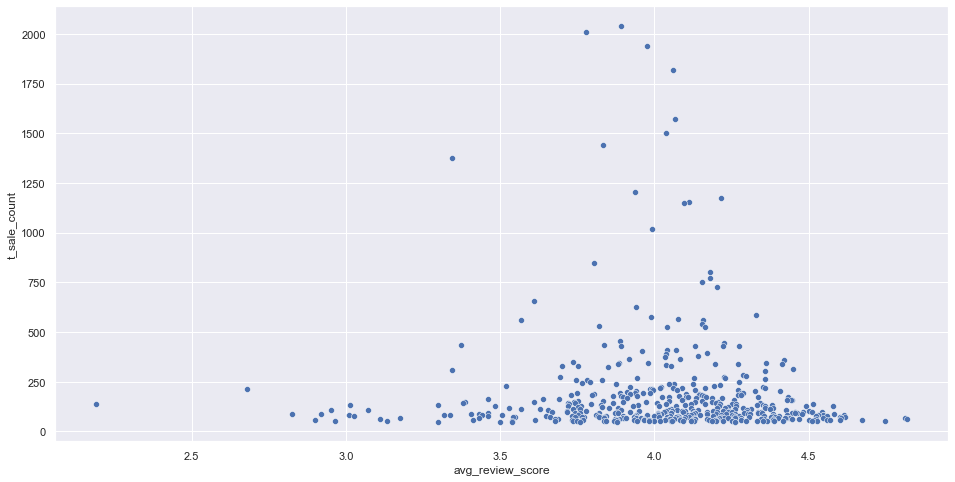

In [24]:
# Rating vs Age
f = plt.figure(figsize=(16, 8))
sb.scatterplot(x = 'avg_review_score', y = 't_sale_count', data = seller_df)

<AxesSubplot:>

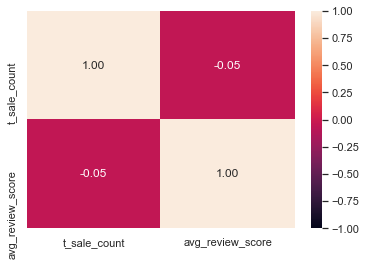

In [25]:
sb.heatmap(seller_df[['t_sale_count','avg_review_score']].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

Observations:
* As shown there is a poor relationship between number of sales and average score
* By common sense, a high average review score would imply that customers are happy
* It would be a bad idea to promote sellers who have bad reputation despite high number of sales
* Hence, sales would be a bad indicator of performance

## Exploratory Analysis: #3 Review Comments
Since sales is not a good indicator let's try to measure review comments?
Let's see if we're able to distinguish the level of satisifaction from the comments from its features.

From our dataset the possible useful columns are:

* `order_id`
* `customer_unique_id`
* `seller_id`
* `review_score`
* `review_comment_message`

# Translating Comment Messages

The review comment messages are in Portuguese, and unfortunately none of our team members know this language. Also, it will be more appropriate if we display information in English for effective communication of our project. Luckily we can use the 
googletrans module to translate the review comment messages.

In [26]:
#from google_trans_new import google_translator
#translator = google_translator()

# t_size = int(len(mf_df.index))
# temp, translate = train_test_split(mf_df,test_size = t_size, random_state=seed)

# translate['translation_comment_message'] = 'NaN'

# translations = []
# for i in range(len(translate.index)):
#     translate['translation_comment_message'].iloc[i] = translator.translate(translate['review_comment_message'].iloc[i],lang_tgt='en',lang_src = 'pt')


Due to API limitations, we have translated and saved the translated reviews into an excel sheet 

# Do review scores scale with how happy customers are?

Lets compare our review scores and comment messages with an external sentimment analyser. TextBlob module has been developed by data scientists. It's a vocabulary which stores different words of english and its polarity. It's able to efficiently detect the sentiment of sentences. Lets use this library on our english translations and calculate their sentiment. After that we can see the correlation review scores and comment message.

> Refer to text_blob_vader.ipynb

### Clean data
To ensure consistency we will do the follow:
* Remove neutral features such as weblinks and special characters
* Ensure all characters are lowercase
* Remove rows with no comments
* Remove duplicate comments for duplicate transactions
* Remove stop words are such as `a`, `the`, etc. are universally neutral.
* Words such as 200 dollars has the same meaning as two hundred dollars. Here we attempt to clean these features by normalization using NLTK's SnowballStemmer.

In [27]:
from nltk.stem.snowball import SnowballStemmer
import re

print(len(mf_df))

#Filter rows with no messages
mf_df = mf_df[mf_df.review_comment_message.notnull()]

#Filter duplicate orders
mf_df = mf_df.drop_duplicates(['order_id'])


#Reindex
mf_df.index = pd.Series(list(range(mf_df.shape[0])))
print(len(mf_df))

#Clean data, convert to lowercase and remove punctuation
def formatReview(string):
    string = ''.join([i for i in string if i.isalpha() or i.isspace()])
    return string.lower()

#Check for urls
def removeWebLinks(string):
    return re.sub('http://\S+|https://\S+|.com\S+', '', string)

#Normalize words
def normalizeFeedback(string):
    portS = SnowballStemmer("portuguese") 
    return portS.stem(string) 


#Remove stop words
def removeStopWords(string):
    stop_words = open('ecomm_data/stopwords.txt').read().splitlines()
    string_ls = string.split()
    return ' '.join([word for word in string_ls if word.lower() not in stop_words]) 

mf_df = mf_df[mf_df.review_comment_message.notnull()]
print(mf_df['review_comment_message'].head(1))
mf_df['review_comment_message'] = mf_df.apply(lambda x: removeWebLinks(x['review_comment_message']), axis=1) 
mf_df['review_comment_message'] = mf_df.apply(lambda x: formatReview(x['review_comment_message']), axis=1)
#mf_df['review_comment_message'] = mf_df.apply(lambda x: removeStopWords(x['review_comment_message']), axis=1) 
#mf_df['review_comment_message'] = mf_df.apply(lambda x: normalizeFeedback(x['review_comment_message']), axis=1)
mf_df = mf_df.loc[mf_df["review_comment_message"]!=""]
print(mf_df['review_comment_message'].head(1))

#drop duplicates
mf_df = mf_df[mf_df.review_comment_message.notnull()]
mf_df = mf_df.drop_duplicates(subset=['order_id'])

114097
41063
0    O baratheon è esxelente Amo adoro o baratheon
Name: review_comment_message, dtype: object
0    o baratheon è esxelente amo adoro o baratheon
Name: review_comment_message, dtype: object


Oberservations:
* Initial 114097 entries have been reduced to 41063

### Supervising the Data
Here we will assume the follow:
* scores >3 are overall satisfactory
* scores ==3 are overall neutral
* scores <3 are overall unsatisfactory

Each comment will be assigned a satisfaction class accordingly

In [28]:
#Classify score
def scoring (score):
    score = float(score)
    if score >= 3.5:
        return 'Satisfactory'
    elif score >= 2.5:
        return 'Neutral'
    else:
        return 'Unsatisfactory'
    
mf_df['score_class'] = mf_df.apply(lambda x: scoring(x['review_score']), axis=1)    

In [29]:
mf_df['score_class'].describe()

count            40910
unique               3
top       Satisfactory
freq             26406
Name: score_class, dtype: object

In [30]:
mf_df[['customer_unique_id','review_comment_message','review_score','score_class']].head()

,customer_unique_id,review_comment_message,review_score,score_class
0,345ecd01c38d18a9036ed96c73b8d066,o baratheon è esxelente amo adoro o baratheon,5.0,Satisfactory
1,4c93744516667ad3b8f1fb645a3116a4,loja responsável,5.0,Satisfactory
2,1175e95fb47ddff9de6b2b06188f7e0d,chegou antes do prometido,5.0,Satisfactory
3,9afe194fb833f79e300e37e580171f22,ótimo entregou antes da data prevista,5.0,Satisfactory
4,2a7745e1ed516b289ed9b29c7d0539a5,td certoproduto e prazo de entrega,5.0,Satisfactory


<AxesSubplot:xlabel='score_class', ylabel='count'>

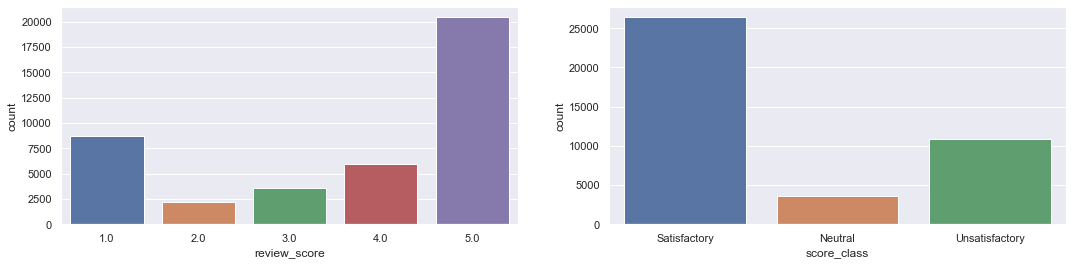

In [31]:
f, axes = plt.subplots(1, 2, figsize=(18, 4))

sb.countplot(x='review_score', data=mf_df, ax = axes[0])
sb.countplot(x='score_class', data=mf_df, ax = axes[1])

Observations:
* We take note that the 3 score classes are not evenly distributed

Lets what are the top reoccuring features of each class.

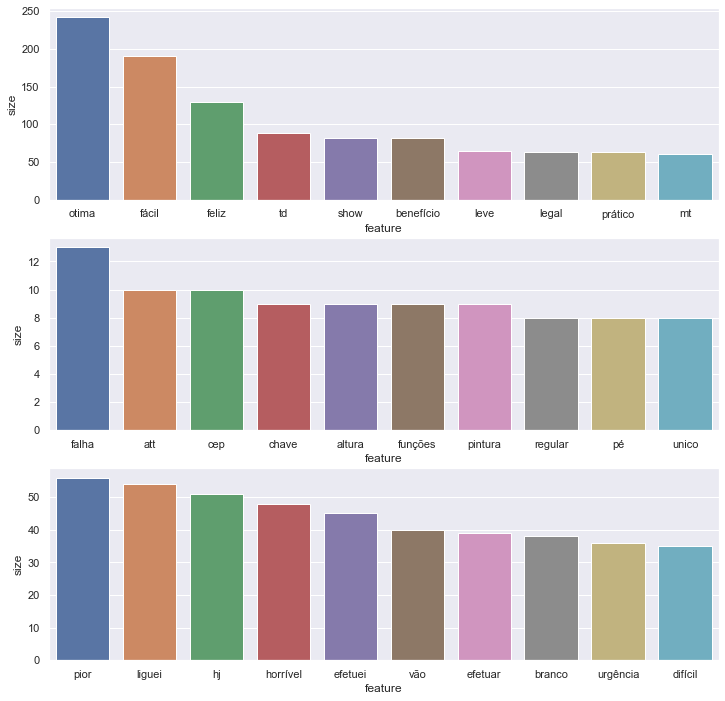

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

score_class_name = ['Satisfactory', 'Neutral', 'Unsatisfactory']

f, axes = plt.subplots(len(score_class_name), figsize=(12, 12))
# Extract unique review features of classes
count=0
for c_name in score_class_name:
    cVect = CountVectorizer(encoding='portuguese-1')
    vCounts = cVect.fit_transform(mf_df['review_comment_message'].loc[mf_df['score_class'].isin([c_name])])
    
    df = pd.DataFrame()
    #df['size'] = (np.asarray(vCounts.sum(axis=0))[0]/len(np.asarray(vCounts.sum(axis=0))[0]))*100
    df['size'] = np.asarray(vCounts.sum(axis=0))[0]
    df['feature'] = cVect.get_feature_names()
    
    df=df.sort_values(by=['size'],ascending=False)
    
    
    #Filter top 10% of features
    for name in score_class_name:
        if name != c_name:
            cVect2 = CountVectorizer(encoding='portuguese-1')
            cCounts_cmp = cVect2.fit_transform(mf_df['review_comment_message'].loc[mf_df['score_class'].isin([name])])
            
            df_cmp = pd.DataFrame()
            df_cmp['size'] = np.asarray(cCounts_cmp.sum(axis=0))[0]
            df_cmp['feature'] = cVect2.get_feature_names()
            df_cmp = df_cmp.sort_values(by=['size'],ascending=False)
            
            for feature in df_cmp['feature'][:int(len(df_cmp['feature'])*0.1)]:
                df = df[~df["feature"].str.contains(feature)]
            
    sb.barplot(x='feature',y='size',data=df[:10],ax = axes[count])
    
    count+=1

In [33]:
df

,size,feature
7482,56,pior
5785,54,liguei
4990,51,hj
5020,48,horrível
3343,45,efetuei
...,...,...
4516,1,fixo
4511,1,fiu
4504,1,fisco
4497,1,fisc


english translation of top 10 features:


> Satisfactory: excellent, easy, happy, td(slang for everything), benefit, show, pratical, level, light, cool, mt(slang for 'A lot') 


> Neutral: failure, respectfully, zip code, functions, altura, key, painting, foot, single, handle


> Unsatisfactory: worst, I called, hj, horrible, disappointed, they go, white, explanation, difficult


Observations:
* The words are generally associated to their assigned classes.
* Possibly viable in estimating the sentiment of reviews

Now we shall attempt to create a model to estimate the sentiment level of each comment.

___

## Machine Learning
### Creating a Model for Sentiment (1):
### Models

Selected Models:

* Random Forest

* Naive Bayes

* Decision Tree

Text Classification
* CountVectorizer
* TF-IDF

Text(0.5, 1.0, 'Sparse Matrix (Train set)')

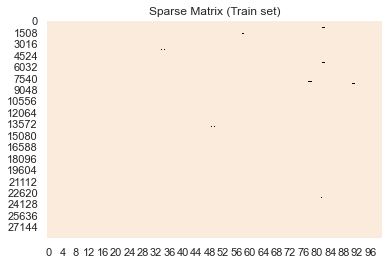

In [34]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Split the Dataset into random Train and Test
test_prec = 0.3;
t_size = int(0.3 * len(mf_df.index))
x_train, x_test, y_train, y_test = train_test_split(mf_df['review_comment_message'],mf_df['score_class'], test_size = t_size, random_state=seed)

#Create TF-IDF Matrix 
vCount = CountVectorizer(encoding='portuguese-1')
x_train_count = vCount.fit_transform(x_train)
tfidf_t = TfidfTransformer(use_idf=True)
x_train_tfidf = tfidf_t.fit_transform(x_train_count)

sb.heatmap(x_train_tfidf.todense()[:,np.random.randint(0,x_train_tfidf.shape[1],100)]==0, 
           vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix (Train set)')

In [35]:
x_train_tfidf.shape

(28637, 14329)

Observations:
* There are 28637  columns and 14329 rows
* There is a large amount of rows and vocabularly is quite huge
* Hence, TF-IDF would be a good choice here.

### Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

#fit train data
rfc = RandomForestClassifier(n_estimators=80)
rfc.fit(x_train_tfidf, y_train)

#predict test data
x_test_count = vCount.transform(x_test)
x_test_tfidf = tfidf_t.transform(x_test_count)

rfc_prediction = rfc.predict(x_test_tfidf)

Text(0.5, 1.0, 'Confusion Matrix: Random Forest')

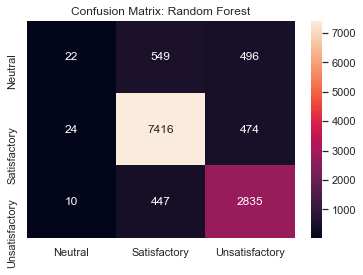

In [37]:
ax = plt.axes()
sb.heatmap(confusion_matrix(y_test, rfc_prediction), 
           annot = True, fmt=".0f", ax=ax, yticklabels=['Neutral','Satisfactory', 'Unsatisfactory'], 
           xticklabels = ['Neutral','Satisfactory', 'Unsatisfactory'])
ax.set_title('Confusion Matrix: Random Forest')


### Naive Bayes

Text(0.5, 1.0, 'Confusion Matrix: Naive Bayes')

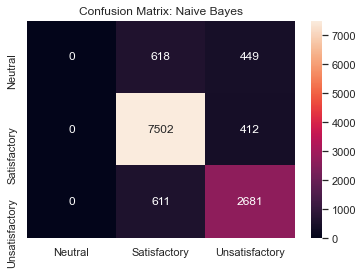

In [38]:
from sklearn.naive_bayes import MultinomialNB

#fit train data
nbc = MultinomialNB()
nbc.fit(x_train_tfidf, y_train)

#predict test data
x_test_count = vCount.transform(x_test)
x_test_tfidf = tfidf_t.transform(x_test_count)

nbc_prediction = nbc.predict(x_test_tfidf)

ax = plt.axes()
sb.heatmap(confusion_matrix(y_test, nbc_prediction), 
           annot = True, fmt=".0f", ax=ax, yticklabels=['Neutral','Satisfactory', 'Unsatisfactory'], 
           xticklabels = ['Neutral','Satisfactory', 'Unsatisfactory'])
ax.set_title('Confusion Matrix: Naive Bayes')


### Decision Tree

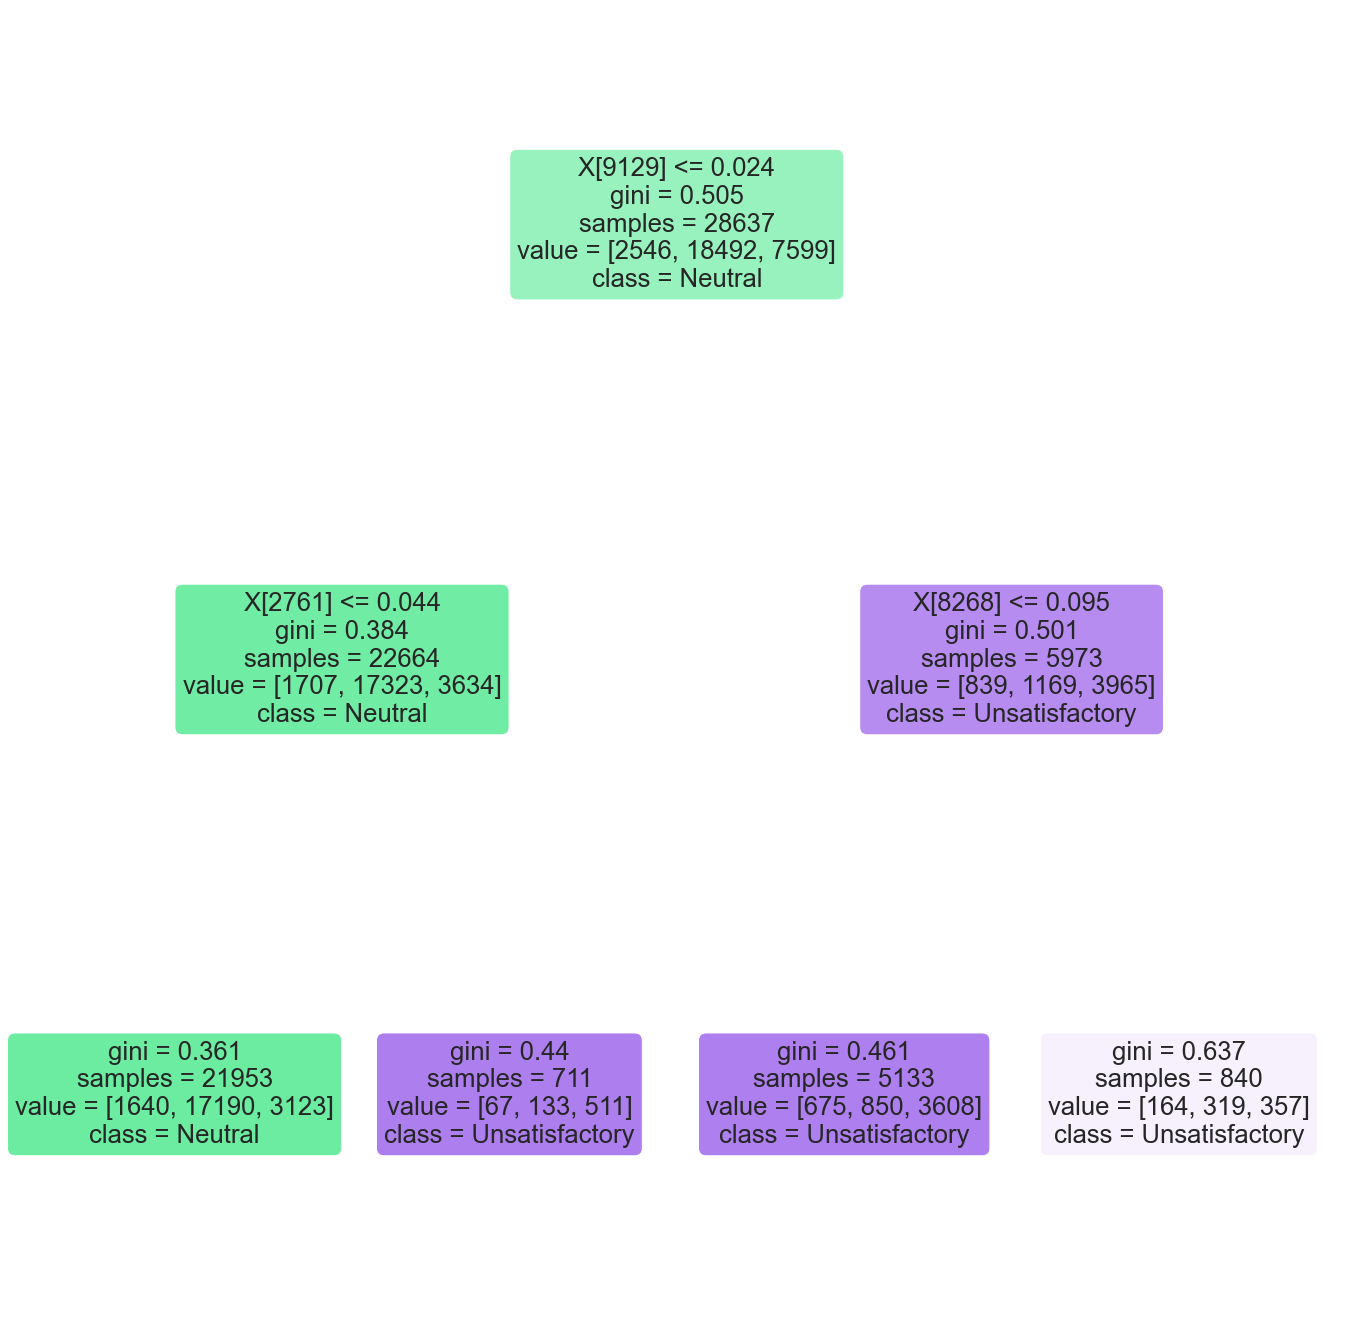

In [39]:
from sklearn.tree import DecisionTreeClassifier

#fit train data
dtc = DecisionTreeClassifier(max_depth =2) 
dtc.fit(x_train_tfidf, y_train)

#predict test data
x_test_count = vCount.transform(x_test)
x_test_tfidf = tfidf_t.transform(x_test_count)

dtc_prediction = dtc.predict(x_test_tfidf)

from sklearn.tree import plot_tree

f = plt.figure(figsize=(24,24))
plot_tree(dtc, filled=True, rounded=True,
         class_names=['Satisfactory', 'Neutral', 'Unsatisfactory'])
plt.show()

Text(0.5, 1.0, 'Confusion Matrix: Decision Tree')

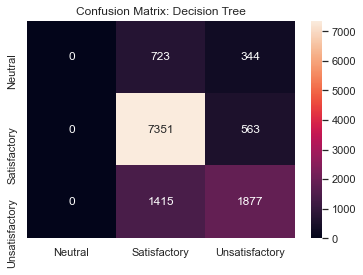

In [40]:
ax = plt.axes()
sb.heatmap(confusion_matrix(y_test, dtc_prediction), 
           annot = True, fmt=".0f", ax=ax, yticklabels=['Neutral','Satisfactory', 'Unsatisfactory'], 
           xticklabels = ['Neutral','Satisfactory', 'Unsatisfactory'])
ax.set_title('Confusion Matrix: Decision Tree')


### Model Analysis

In [41]:
cPred_result_table = pd.DataFrame({
    'Model':[],
    'Accuracy':[],
    'TSR':[],
    'TNR':[],
    'TUR':[],
    'FSR':[],
    'FNR':[],
    'FUR':[]
})
cModel_ls = ['Random Forest', 'Naive Bayes', 'Decision Tree']
cPrediction_ls = [rfc_prediction, nbc_prediction, dtc_prediction]

#Construct table for model analysis
count = 0;
for prediction in cPrediction_ls:
    cmTest = confusion_matrix(y_test, prediction)

    
    tnTest = cmTest[0][0]
    tsTest = cmTest[1][1]
    tuTest = cmTest[2][2]
    
    fnTest = cmTest[0][1] + cmTest[0][2]
    fsTest = cmTest[1][0] + cmTest[1][2]
    fuTest = cmTest[2][0] + cmTest[2][1]
    
    tsr = tsTest/(tsTest + fsTest)
    tur = tuTest/(tuTest + fuTest)
    tnr = tnTest/(tnTest + fnTest)
    fsr = fsTest/(fsTest + tsTest)
    fur = fuTest/(fuTest + tuTest)
    fnr = fnTest/(fnTest + tnTest)

   
    accuracy = accuracy_score(y_test, prediction)

    cPred_result_table.loc[count] = [cModel_ls[count],accuracy,tsr,tnr,tur,fsr,fnr,fur]
    
    count+=1

cPred_result_table = cPred_result_table.sort_values(by='Accuracy', ascending=False)

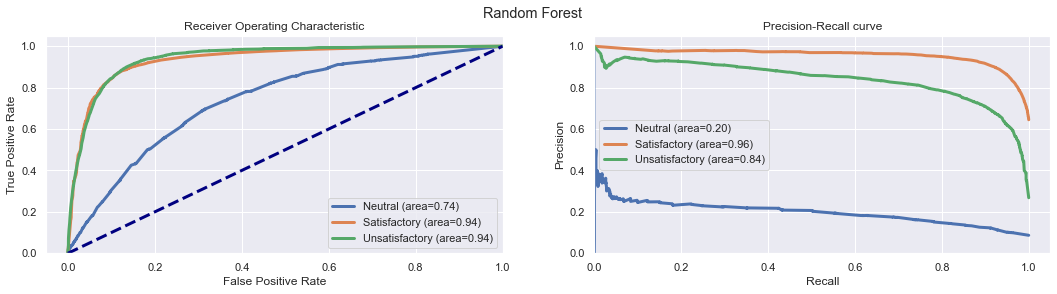

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
## Plot roc
roc_y_test = pd.get_dummies(y_test, drop_first=False).values
rfc_prob = rfc.predict_proba(x_test_tfidf)
classes = np.unique(y_test)

for i in range(3):
    fpr, tpr, thresholds = roc_curve(roc_y_test[:,i],  rfc_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))

ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate", 
          title="Receiver Operating Characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

for i in range(3):
    precision, recall, thresholds = precision_recall_curve(roc_y_test[:,i], rfc_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)

fig.suptitle('Random Forest')
plt.show()

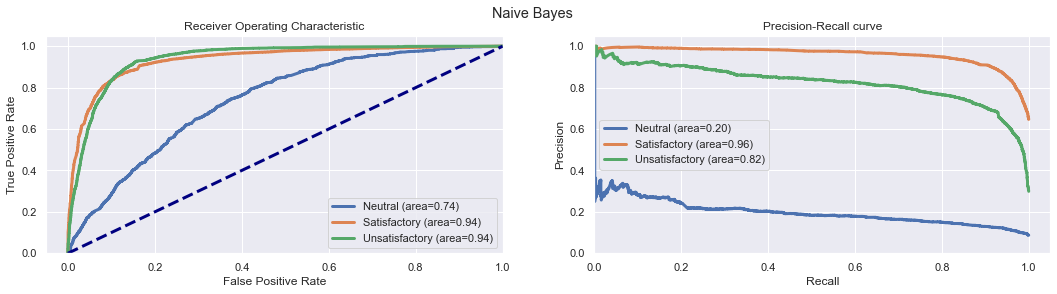

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
## Plot roc
roc_y_test = pd.get_dummies(y_test, drop_first=False).values
rfc_prob = nbc.predict_proba(x_test_tfidf)
classes = np.unique(y_test)

for i in range(3):
    fpr, tpr, thresholds = roc_curve(roc_y_test[:,i],  rfc_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))

ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate", 
          title="Receiver Operating Characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

for i in range(3):
    precision, recall, thresholds = precision_recall_curve(roc_y_test[:,i], rfc_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)

fig.suptitle('Naive Bayes')
plt.show()

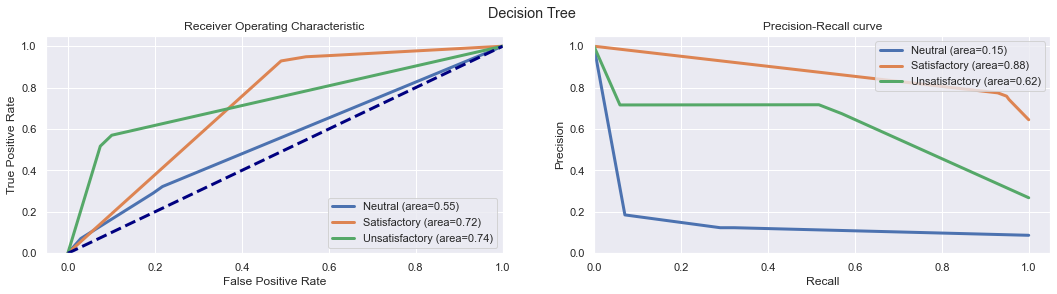

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
## Plot roc
roc_y_test = pd.get_dummies(y_test, drop_first=False).values
rfc_prob = dtc.predict_proba(x_test_tfidf)
classes = np.unique(y_test)

for i in range(3):
    fpr, tpr, thresholds = roc_curve(roc_y_test[:,i],  rfc_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))

ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate", 
          title="Receiver Operating Characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

for i in range(3):
    precision, recall, thresholds = precision_recall_curve(roc_y_test[:,i], rfc_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)

fig.suptitle('Decision Tree')
plt.show()

In [45]:
# Confusion matrix is 3x3 ... TPR AND TNR only make sense for 2x2 matrices
# TSR -> True satisfactory rate, 
# TNR -> True Neutral rate,
# TUR -> True unsatisfactory rate ...
display(cPred_result_table)

,Model,Accuracy,TSR,TNR,TUR,FSR,FNR,FUR
0,Random Forest,0.837041,0.937074,0.020619,0.861179,0.062926,0.979381,0.138821
1,Naive Bayes,0.829707,0.947940,0.000000,0.814399,0.052060,1.000000,0.185601
2,Decision Tree,0.751894,0.928860,0.000000,0.570170,0.071140,1.000000,0.429830


Observations:
* The TNR value is extrememly low, for model cases. 
* It would be a good idea to discard `Neutral`, and categorize our data by `Satisfactory` and `Unsatisfactory` instead. * 
* High accuracy of `80%` caused by the inbalance of `Neutral` features.

### Model lmprovement:

Here we remove neutral rows and retrain our model

In [46]:

mf_df = mf_df[(mf_df['review_score'] >=3.5) | (mf_df['review_score'] <2.5)]



# Split the Dataset into random Train and Test
test_prec = 0.3;
t_size = int(0.3 * len(mf_df.index))
x_train, x_test, y_train, y_test = train_test_split(mf_df['review_comment_message'],mf_df['score_class'], test_size = t_size,random_state=seed)


###Retrain###
#Create TF-IDF Matrix 
vCount = CountVectorizer(encoding='portuguese-1')
x_train_count = vCount.fit_transform(x_train)
tfidf_t = TfidfTransformer(use_idf=True)
x_train_tfidf = tfidf_t.fit_transform(x_train_count)

##Random Forest##
#fit train data
rfc = RandomForestClassifier(n_estimators=80)
rfc.fit(x_train_tfidf, y_train)

#predict test data
x_test_count = vCount.transform(x_test)
x_test_tfidf = tfidf_t.transform(x_test_count)
rfc_prediction = rfc.predict(x_test_tfidf)

##Naive Bayes##
#fit train data
nbc = MultinomialNB()
nbc.fit(x_train_tfidf, y_train)

#predict test data
x_test_count = vCount.transform(x_test)
x_test_tfidf = tfidf_t.transform(x_test_count)
nbc_prediction = nbc.predict(x_test_tfidf)

##Decision Tree##
dtc = DecisionTreeClassifier(max_depth =2) 
dtc.fit(x_train_tfidf, y_train)
dtc_prediction = dtc.predict(x_test_tfidf)

#predict test data
x_test_count = vCount.transform(x_test)
x_test_tfidf = tfidf_t.transform(x_test_count)


###Generate Table###
cPred_result_table = pd.DataFrame({
    'Model':[],
    'Accuracy':[],
    'TSR':[],
    'TUR':[],
    'FSR':[],
    'FUR':[]
})
cModel_ls = ['Random Forest', 'Naive Bayes', 'Decision Tree']
cPrediction_ls = [rfc_prediction, nbc_prediction, dtc_prediction]

#Construct table for model analysis
count = 0;
for prediction in cPrediction_ls:
    cmTest = confusion_matrix(y_test, prediction)
    

    ##Generate Model Analysis##
    cmTest = confusion_matrix(y_test, rfc_prediction)
    tpTest = cmTest[1][1] 
    fpTest = cmTest[0][1] 
    tnTest = cmTest[0][0] 
    fnTest = cmTest[1][0] 
    tur = (tpTest/(tpTest + fnTest))
    tsr = (tnTest/(tnTest + fpTest))
    fur = fpTest/(fpTest + tnTest)
    fsr = fnTest/(fnTest + tpTest)
    
    accuracy = accuracy_score(y_test, prediction)

    cPred_result_table.loc[count] = [cModel_ls[count],accuracy,tsr,tur,fsr,fur]
    
    count+=1

cPred_result_table = cPred_result_table.sort_values(by='Accuracy', ascending=False)

Text(0.5, 1.0, 'Confusion Matrix: Random Forest')

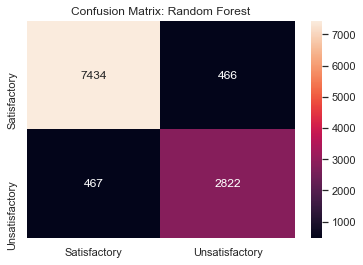

In [47]:
ax = plt.axes()
sb.heatmap(confusion_matrix(y_test, rfc_prediction), 
           annot = True, fmt=".0f", ax=ax, yticklabels=['Satisfactory', 'Unsatisfactory'], 
           xticklabels = ['Satisfactory', 'Unsatisfactory'])
ax.set_title('Confusion Matrix: Random Forest')

Text(0.5, 1.0, 'Confusion Matrix: Naive Bayes')

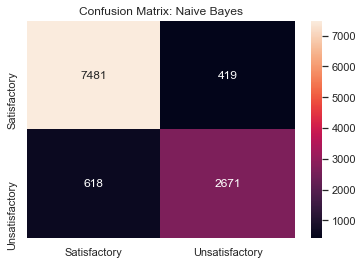

In [48]:

ax = plt.axes()
sb.heatmap(confusion_matrix(y_test, nbc_prediction), 
           annot = True, fmt=".0f", ax=ax, yticklabels=['Satisfactory', 'Unsatisfactory'], 
           xticklabels = ['Satisfactory', 'Unsatisfactory'])
ax.set_title('Confusion Matrix: Naive Bayes')


Text(0.5, 1.0, 'Confusion Matrix: Decision Tree')

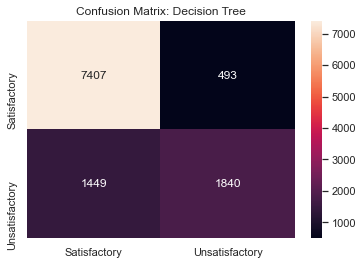

In [49]:
ax = plt.axes()
sb.heatmap(confusion_matrix(y_test, dtc_prediction), 
           annot = True, fmt=".0f", ax=ax, yticklabels=['Satisfactory', 'Unsatisfactory'], 
           xticklabels = ['Satisfactory', 'Unsatisfactory'])
ax.set_title('Confusion Matrix: Decision Tree')


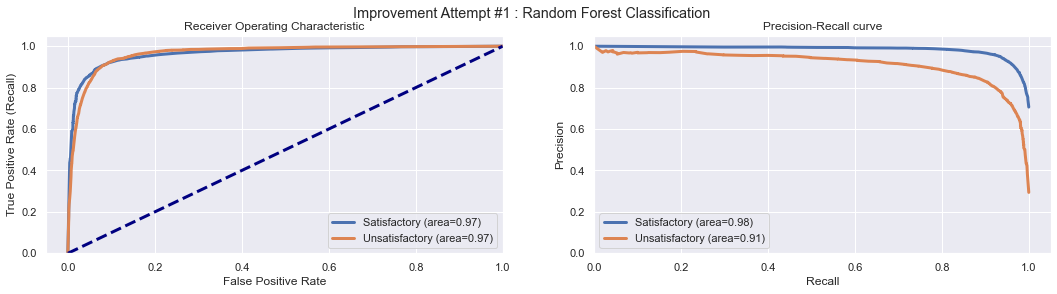

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
## Plot roc
roc_y_test = pd.get_dummies(y_test, drop_first=False).values
rfc_prob = rfc.predict_proba(x_test_tfidf)
classes = np.unique(y_test)

for i in range(2):
    fpr, tpr, thresholds = roc_curve(roc_y_test[:,i],  rfc_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))

ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver Operating Characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

for i in range(2):
    precision, recall, thresholds = precision_recall_curve(roc_y_test[:,i], rfc_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)

fig.suptitle('Improvement Attempt #1 : Random Forest Classification')
plt.show()

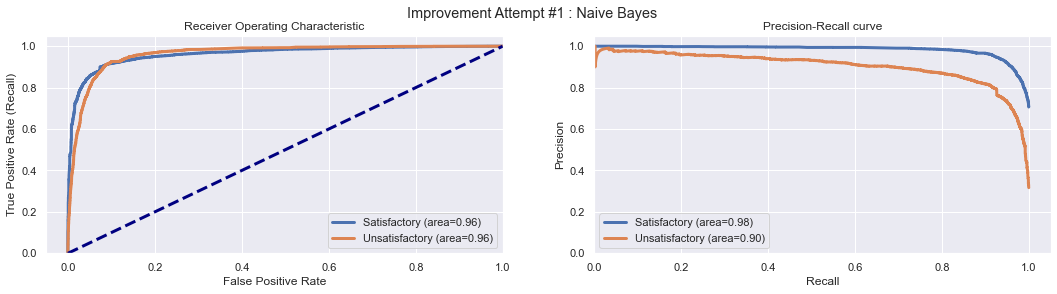

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
## Plot roc
roc_y_test = pd.get_dummies(y_test, drop_first=False).values
rfc_prob = nbc.predict_proba(x_test_tfidf)
classes = np.unique(y_test)

for i in range(2):
    fpr, tpr, thresholds = roc_curve(roc_y_test[:,i],  rfc_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))

ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver Operating Characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

for i in range(2):
    precision, recall, thresholds = precision_recall_curve(roc_y_test[:,i], rfc_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)

fig.suptitle('Improvement Attempt #1 : Naive Bayes')
plt.show()

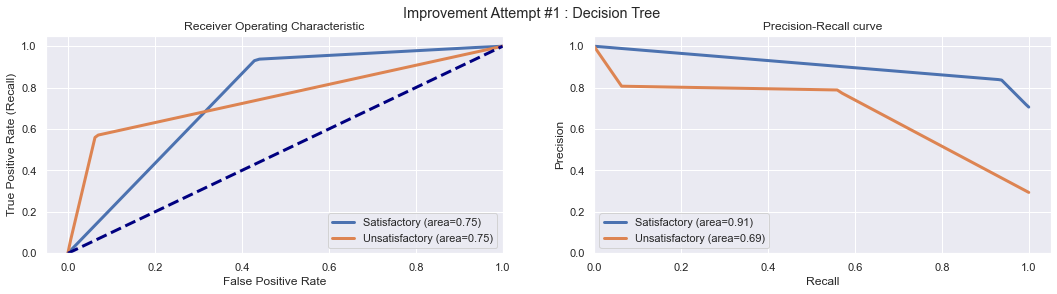

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
## Plot roc
roc_y_test = pd.get_dummies(y_test, drop_first=False).values
rfc_prob = dtc.predict_proba(x_test_tfidf)
classes = np.unique(y_test)

for i in range(2):
    fpr, tpr, thresholds = roc_curve(roc_y_test[:,i],  rfc_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))

ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver Operating Characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

for i in range(2):
    precision, recall, thresholds = precision_recall_curve(roc_y_test[:,i], rfc_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)

fig.suptitle('Improvement Attempt #1 : Decision Tree')
plt.show()

In [53]:
display(cPred_result_table)

,Model,Accuracy,TSR,TUR,FSR,FUR
0,Random Forest,0.916615,0.941013,0.858012,0.141988,0.058987
1,Naive Bayes,0.907320,0.941013,0.858012,0.141988,0.058987
2,Decision Tree,0.826437,0.941013,0.858012,0.141988,0.058987


Observations:
* Due to the neutral features from the rows, we see a slight decrease in performance TSR and TUR
* However overall accuracy has improved

Selecting Our Model:
* Earlier we noted that there was a inbalance in satisafactory and unsatisfactory data
* Hence we may use Precision-Recall curve to estimate the performance
* Naive Bayes and Random forest has similar area under the curve.
* However under our project setting, which is a large data set and assumed independent features within the reviews
* Due to the overfitting nature of random forest, Naive Bayes would be the better choice.
* Hence we chose Naive Bayes as our Model.

### Testing Our Final Model 

In [54]:
test_count_unknown = vCount.transform([""])
test_tfidf_unknown = tfidf_t.transform(test_count_unknown)
unknown_feedback_prediciton = rfc.predict_proba(test_tfidf_unknown)
                  
def make_prediction_nb(string):
    #Clean
    string = formatReview(removeWebLinks(string))
    
    #Set to neutral if cleaned string is empty
    if string == "":
        return ["Neutral"], np.array([0.5,0.5])
            
    #vectorize 
    test_count = vCount.transform([string])
    test_tfidf = tfidf_t.transform(test_count)
    
    #predict
    rfc_prediction = nbc.predict(test_tfidf)
    rfc_probability = nbc.predict_proba(test_tfidf)
    
    #Set to neutral if unknown
    global unknown_feedback_prediciton
    if(np.array_equal(rfc_probability, unknown_feedback_prediciton,equal_nan=True)):
        return "Neutral", np.array([0.5,0.5])
        
    return rfc_prediction[0], rfc_probability


#excellent product
feedback = "produto excelente"
#Terrible
feedback_1 = "terrível"

print("Simulation:")
print("Feedback: ", feedback)
prediction, probability = make_prediction_nb(feedback)
print("Analysis: ",probability[0,0]*100,"% \t", prediction)
print("Feedback: ", feedback_1)
prediction, probability = make_prediction_nb(feedback_1)
print("Analysis: ",probability[0,1]*100,"% \t", prediction)

Simulation:
Feedback:  produto excelente
Analysis:  99.36639232344218 % 	 Satisfactory
Feedback:  terrível
Analysis:  44.122630782989646 % 	 Satisfactory


Observations
* It works!
* producto excelente translates to excellent product recieved a satisfactory score of 98%. (Sentiment 0.98)
* producto terrivel translates to terrible recieved a satisfactory score of 48%. (Sentiment 0.48)

#### Calculate Sentiment for All Rows

Will be used later for analysis

In [55]:
def sentiment(string):    
    #Set to neutral if cleaned string is empty
    if string == "":
        return 0.5
            
    #vectorize 
    test_count = vCount.transform([string])
    test_tfidf = tfidf_t.transform(test_count)
    
    #predict
    rfc_prediction = nbc.predict(test_tfidf)
    rfc_probability = nbc.predict_proba(test_tfidf)
    
    #Set to neutral if unknown
    global unknown_feedback_prediciton
    if(np.array_equal(rfc_probability, unknown_feedback_prediciton,equal_nan=True)):
        return 0.5
        
    return rfc_probability[0,0]


mf_df['sentiment'] = mf_df.apply(lambda x: sentiment(x['review_comment_message']), axis=1) 

***

# Sentiment Analysis 

Now we shall conduct a sentiment analysis on all our previous feedback.

#### Sentiment Distribution Across Customers

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

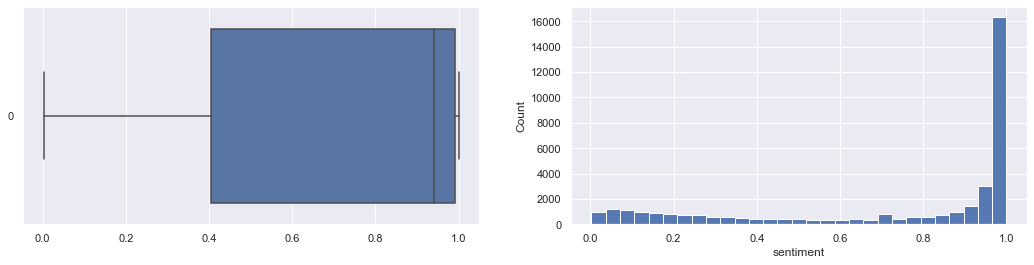

In [56]:
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(data = mf_df['sentiment'], orient = "h", ax = axes[0])
sb.histplot(data = mf_df['sentiment'], ax = axes[1])
sb.histplot(data = mf_df['sentiment'], ax = axes[1])

In [57]:
mf_df[['sentiment']].describe()

,sentiment
count,37297.000000
mean,0.721297
std,0.346569
min,0.002381
25%,0.405653
50%,0.941759
75%,0.991437
max,0.999955


Observation:
* As we noticed, sentiment distribution is heavily concentrated close to the 1.0 value. 

Now, let's try to find the average sentiment for each company.

#### Average Sentiment of Each Company

In [58]:
mf_df = mf_df[mf_df.seller_id.notnull()]

try:
    sellers.set_index('seller_id',inplace=True)
except:
    pass

sellers['avg_sentiment'] = 0
sellers['total_feedback'] = 0

for index, row in mf_df.iterrows():        
    if(sellers.loc[row['seller_id'],'avg_sentiment'] == 0):
        sellers.loc[row['seller_id'],'avg_sentiment'] = row['sentiment']

    else:
        sellers.loc[row['seller_id'],'avg_sentiment'] = (sellers.loc[row['seller_id'],'avg_sentiment'] +  row['sentiment'])/2
        
    sellers.loc[row['seller_id'],'total_feedback'] += 1
    
sellers = sellers[sellers['avg_sentiment'] != 0]

<AxesSubplot:xlabel='avg_sentiment'>

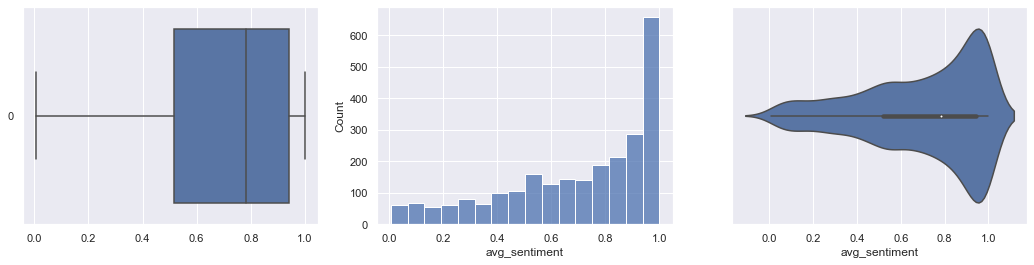

In [59]:
f, axes = plt.subplots(1, 3, figsize=(18, 4))
sb.boxplot(data = sellers['avg_sentiment'], orient = "h", ax = axes[0])
sb.histplot(data = sellers['avg_sentiment'], ax = axes[1])
sb.violinplot(data = sellers, x = 'avg_sentiment', ax = axes[2])


In [60]:
sellers = sellers.sort_values(by='total_feedback', ascending=False)
sellers[['avg_sentiment']].describe()

,avg_sentiment
count,2508.000000
mean,0.699400
std,0.276351
min,0.006835
25%,0.517542
50%,0.782315
75%,0.942111
max,0.999897


<AxesSubplot:xlabel='avg_sentiment'>

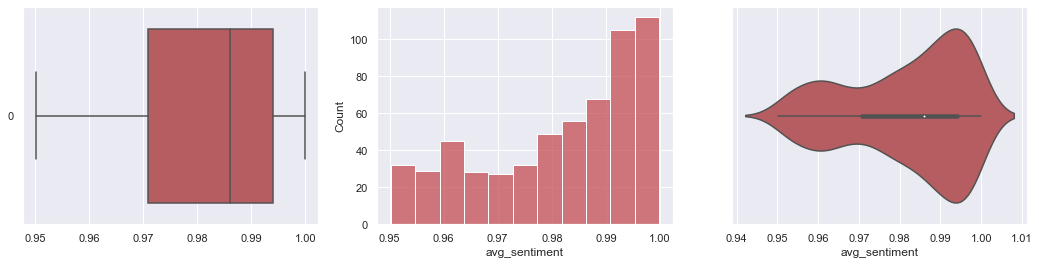

In [61]:
sellers_filter = sellers[sellers['avg_sentiment'] >= 0.95]

f, axes = plt.subplots(1, 3, figsize=(18, 4))
sb.boxplot(data = sellers_filter['avg_sentiment'], orient = "h", ax = axes[0],color = 'r')
sb.histplot(data = sellers_filter['avg_sentiment'], ax = axes[1],color = 'r')
sb.violinplot(data = sellers_filter, x = 'avg_sentiment', ax=axes[2],color = 'r')


In [62]:
sellers_filter[['avg_sentiment']].describe()

,avg_sentiment
count,583.000000
mean,0.981686
std,0.014480
min,0.950207
25%,0.970807
50%,0.985987
75%,0.993969
max,0.999897


Observation:
* Now we see an improved distribution. 

In [63]:
sellers = sellers.sort_values(by='t_sale_count', ascending=False)
sellers[['avg_sentiment','avg_review_score','t_sale_count']].head()

,avg_sentiment,avg_review_score,t_sale_count
seller_id,,,
6560211a19b47992c3666cc44a7e94c0,0.903715,3.891614,2039
4a3ca9315b744ce9f8e9374361493884,0.915849,3.777501,2009
1f50f920176fa81dab994f9023523100,0.670952,3.975773,1940
cc419e0650a3c5ba77189a1882b7556a,0.451607,4.061572,1819
da8622b14eb17ae2831f4ac5b9dab84a,0.489665,4.066709,1574


Observation:
* Here we can see that a large number of sales may not always infer that customers are happy.

Now, we shall try to lower the amount of candidates.

#### Filtering Sellers by Number of Feedback

Setting the threshold to minimum of 20 feedback, we reduce our number of candidates

In [64]:
sellers = sellers.sort_values(by='avg_sentiment', ascending=False)
sellers = sellers[sellers['total_feedback'] >20]
sellers.head()

,seller_zip_code_prefix,seller_city,seller_state,avg_review_score,review_score_total,review_count,t_sale,t_sale_count,avg_sale,avg_sentiment,total_feedback
seller_id,,,,,,,,,,,
6cd68b3ed6d59aaa9fece558ad360c0a,31255,belo horizonte,MG,4.445860,698.0,157,11188.57,157,71.264777,0.993953,53
a5cba26a62b8b4d0145b68b841e62e7f,87303,campo mourao,PR,4.527273,249.0,55,14737.84,55,267.960727,0.992534,29
289cdb325fb7e7f891c38608bf9e0962,31570,belo horizonte,SP,4.579365,577.0,126,13544.95,126,107.499603,0.990130,43
9646c3513289980f17226a2fc4720dbd,12215,sao jose dos campos,SP,4.256410,332.0,78,3039.30,78,38.965385,0.989414,25
670c26e0f1bf8d0576271d5cfaec6d2b,87025,maringa,PR,4.310345,375.0,87,6341.60,87,72.891954,0.988909,26


<AxesSubplot:xlabel='avg_sentiment'>

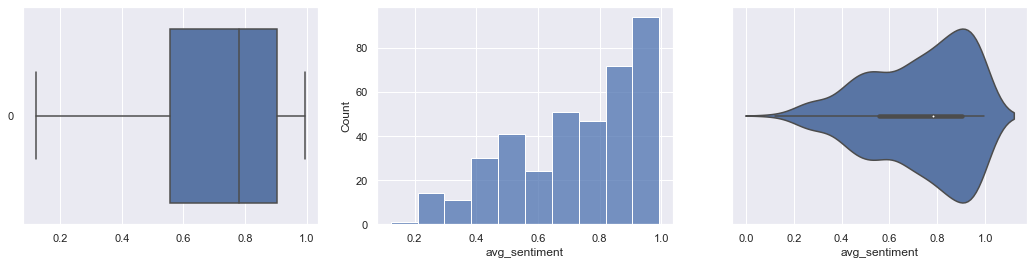

In [65]:
f, axes = plt.subplots(1, 3, figsize=(18, 4))
sb.boxplot(data = sellers['avg_sentiment'], orient = "h", ax = axes[0])
sb.histplot(data = sellers['avg_sentiment'], ax = axes[1])
sb.violinplot(data = sellers, x = 'avg_sentiment', ax = axes[2])

In [66]:
sellers['avg_sentiment'].describe()

count    385.000000
mean       0.727813
std        0.207349
min        0.122850
25%        0.558008
50%        0.780466
75%        0.904424
max        0.993953
Name: avg_sentiment, dtype: float64

<AxesSubplot:xlabel='avg_sentiment'>

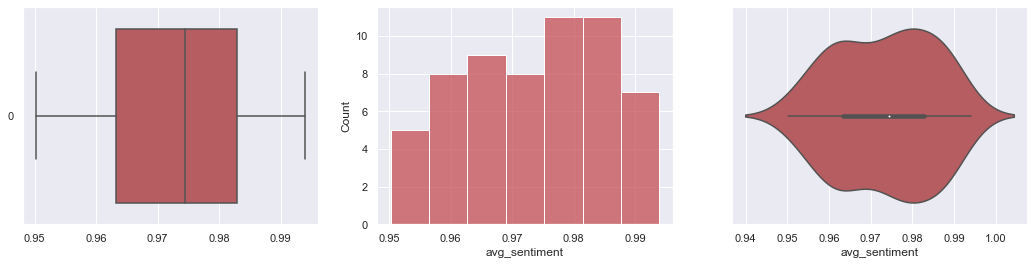

In [67]:
sellers_filter = sellers[sellers['avg_sentiment'] >= 0.95]

f, axes = plt.subplots(1, 3, figsize=(18, 4))
sb.boxplot(data = sellers_filter['avg_sentiment'], orient = "h", ax = axes[0],color = 'r')
sb.histplot(data = sellers_filter['avg_sentiment'], ax = axes[1],color = 'r')
sb.violinplot(data = sellers_filter, x = 'avg_sentiment', ax=axes[2],color = 'r')


In [68]:
sellers_filter[['avg_sentiment']].describe()

,avg_sentiment
count,59.000000
mean,0.973339
std,0.011696
min,0.950257
25%,0.963296
50%,0.974453
75%,0.982878
max,0.993953


Observation:
* Distribution has further improved above 75% quartile

#### Filtering Sellers by Sales

Let's continue by setting the total number of sales threshold to > 75% percentile of sellers 

In [69]:
sellers[['t_sale_count']].describe()

,t_sale_count
count,385.000000
mean,213.127273
std,281.263846
min,34.000000
25%,85.000000
50%,127.000000
75%,211.000000
max,2039.000000


Observation:
* 75 percentile is 211

In [70]:
sellers['sales'] = 0
sellers['revenue'] = 0
for index, row in mf_df.iterrows():
    if(pd.notna(row['seller_id']) and (row['seller_id'] in sellers.index)):
        sellers.loc[row['seller_id'],'sales'] += 1
        sellers.loc[row['seller_id'],'revenue'] += row['price']

sellers.head()

,seller_zip_code_prefix,seller_city,seller_state,avg_review_score,review_score_total,review_count,t_sale,t_sale_count,avg_sale,avg_sentiment,total_feedback,sales,revenue
seller_id,,,,,,,,,,,,,
6cd68b3ed6d59aaa9fece558ad360c0a,31255,belo horizonte,MG,4.445860,698.0,157,11188.57,157,71.264777,0.993953,53,53,3773.5
a5cba26a62b8b4d0145b68b841e62e7f,87303,campo mourao,PR,4.527273,249.0,55,14737.84,55,267.960727,0.992534,29,29,8406.4
289cdb325fb7e7f891c38608bf9e0962,31570,belo horizonte,SP,4.579365,577.0,126,13544.95,126,107.499603,0.990130,43,43,4878.0
9646c3513289980f17226a2fc4720dbd,12215,sao jose dos campos,SP,4.256410,332.0,78,3039.30,78,38.965385,0.989414,25,25,893.8
670c26e0f1bf8d0576271d5cfaec6d2b,87025,maringa,PR,4.310345,375.0,87,6341.60,87,72.891954,0.988909,26,26,2179.3


<AxesSubplot:xlabel='avg_sentiment'>

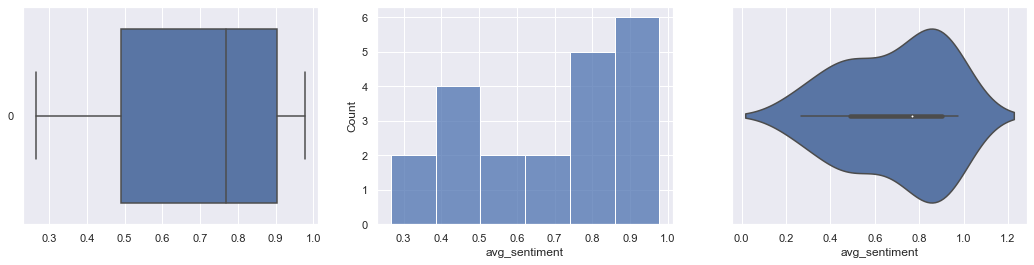

In [71]:
sellers = sellers[sellers['sales'] >= 211]

f, axes = plt.subplots(1,3, figsize=(18, 4))
sb.boxplot(data = sellers['avg_sentiment'], orient = "h", ax = axes[0])
sb.histplot(data = sellers['avg_sentiment'], ax = axes[1])
sb.violinplot(data = sellers, x = 'avg_sentiment', ax = axes[2])

In [72]:
sellers['avg_sentiment'].describe()

count    21.000000
mean      0.689704
std       0.229161
min       0.265903
25%       0.489665
50%       0.769588
75%       0.903715
max       0.977182
Name: avg_sentiment, dtype: float64

<AxesSubplot:xlabel='avg_sentiment'>

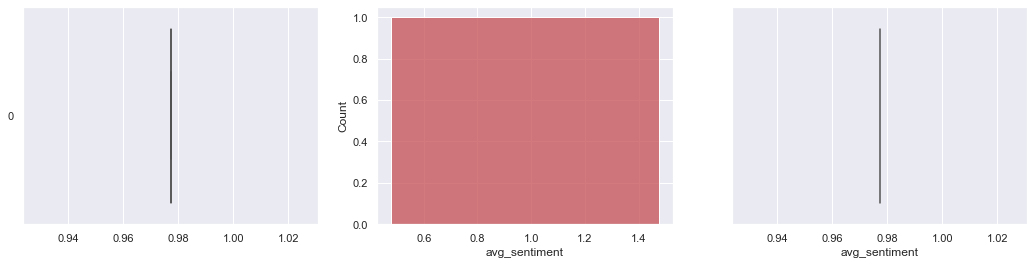

In [73]:
sellers_filter = sellers[sellers['avg_sentiment'] >= 0.95]

f, axes = plt.subplots(1, 3, figsize=(18, 4))
sb.boxplot(data = sellers_filter['avg_sentiment'], orient = "h", ax = axes[0],color = 'r')
sb.histplot(data = sellers_filter['avg_sentiment'], ax = axes[1],color = 'r')
sb.violinplot(data = sellers_filter, x = 'avg_sentiment', ax=axes[2],color = 'r')


In [74]:
sellers[['avg_sentiment', 't_sale_count','total_feedback']].head()

,avg_sentiment,t_sale_count,total_feedback
seller_id,,,
7a67c85e85bb2ce8582c35f2203ad736,0.977182,1175,449
fa1c13f2614d7b5c4749cbc52fecda94,0.938352,586,255
cca3071e3e9bb7d12640c9fbe2301306,0.936535,849,303
f8db351d8c4c4c22c6835c19a46f01b0,0.924391,726,236
4a3ca9315b744ce9f8e9374361493884,0.915849,2009,751


In [75]:
sellers[['avg_sentiment']].describe()

,avg_sentiment
count,21.000000
mean,0.689704
std,0.229161
min,0.265903
25%,0.489665
50%,0.769588
75%,0.903715
max,0.977182


<AxesSubplot:xlabel='t_sale_count', ylabel='avg_sentiment'>

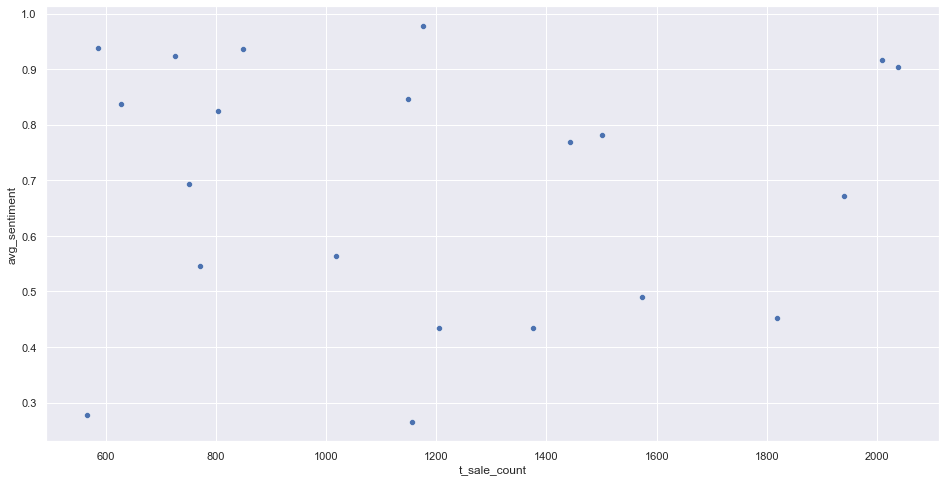

In [76]:
f = plt.figure(figsize=(16, 8))
sb.scatterplot(x = 't_sale_count', y = 'avg_sentiment', data = sellers)


<AxesSubplot:>

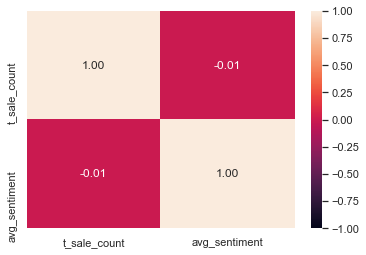

In [77]:
sb.heatmap(sellers[['t_sale_count','avg_sentiment']].corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

Observation:
* There is almost no correlation with total number of sales of a seller to the average sentiment of a seller

In [78]:
sellers = sellers.sort_values(by=['avg_sentiment'],ascending=False)

sellers[['avg_sentiment','avg_review_score','t_sale','sales']].head()

,avg_sentiment,avg_review_score,t_sale,sales
seller_id,,,,
7a67c85e85bb2ce8582c35f2203ad736,0.977182,4.217021,142325.49,449
fa1c13f2614d7b5c4749cbc52fecda94,0.938352,4.327645,194042.03,255
cca3071e3e9bb7d12640c9fbe2301306,0.936535,3.804476,65629.96,303
f8db351d8c4c4c22c6835c19a46f01b0,0.924391,4.201102,50626.40,236
4a3ca9315b744ce9f8e9374361493884,0.915849,3.777501,202999.12,751


In [79]:
sellers['avg_sentiment'].count()

21

Conclusion:
* Now we have successfully identified 5 sellers to display on our webpage.

---

# Additional Explatory Analysis (Not presented)

# Biased Comments (Delivery Based)

Customer reviews are not always addressed towards the quality of the product but a lot of time regarding the delivery of the product. A lot of customers face problems such as late delivery, failed delivery, broken products. Transportation and delivery of the product affects the sentiments of the customers. Sellers don't have anything to do with this. Threrefore, it is unfair for sellers to be demoted in our model because of bad delivery. Hence, we sought out to find below the correlation between the quality of delivery and the sentiment in the customer reviews

### Classifying a product as late
We have information about the promised delivery date and the actual delivery date in the "olist_orders_dataset". By finding out the difference between these dates, we can find out if the delivery is "early" / "late" / "on-time"

#### Data Preperation

In [80]:
orders = pd.read_csv('ecomm_data/olist_orders_dataset.csv')
print(orders.shape)
orders.head()

(99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [81]:
orders = orders[orders.order_delivered_customer_date.notnull()]
orders = orders[orders.order_estimated_delivery_date.notnull()]
orders = orders.merge(review_df, on = "order_id")
print(orders.shape)

(97013, 14)


In [82]:
def stringSplitter(y):
    year = int(y[0:4])
    month = int(y[5:7])
    date = int(y[8:10])
    return year, month, date

e_date = {}
e_month = {}
e_year = {}

a_date = {}
a_month = {}
a_year = {}



timing = {}



# Traverse through the datasets and record values for the timing dataset.

for i in orders.index:
    date1 = stringSplitter(orders['order_estimated_delivery_date'][i])
    e_year.update({ i : date1[0]})
    e_month.update({i :  date1[1]})
    e_date.update({i : date1[2]})
    
    date2 = stringSplitter(orders['order_delivered_customer_date'][i])
    a_year.update({ i : date2[0]})
    a_month.update({i :  date2[1]})
    a_date.update({i : date2[2]})
    
    if(date2[0]>date1[0]):
        timing.update({i : "Late"})
    elif(date2[0]<date1[0]):
        timing.update({i : "Early"})
    else:
        if(date2[1]>date1[1]):
            timing.update({i : "Late"})
        elif(date2[1]<date1[1]):
            timing.update({i : "Early"})
        else:
            if(date2[2]>date1[2]):
                timing.update({i : "Late"})
            elif(date2[2]<date1[2]):
                timing.update({i : "Early"})
            else:
                timing.update({i : "On-time"})
        
   
eVa_df = pd.DataFrame(orders[["order_id", "customer_id", "order_status", "order_delivered_customer_date", "order_estimated_delivery_date"]])    
eVa_df.head()

e_date = pd.Series(e_date)
e_month = pd.Series(e_month)
e_year = pd.Series(e_year)
a_date = pd.Series(a_date)
a_month = pd.Series(a_month)
a_year = pd.Series(a_year)
timing = pd.Series(timing)
data = pd.DataFrame({"expected_date" : e_date, "expected_month" : e_month, "expected_year" : e_year,  "actual_date" : a_date, "actual_month" : a_month, "actual_year" : a_year, "timing" : timing})
orders['timing'] = timing

We have produced a column in the data frame called "timing." This column displays information about whether the product was on-time / early/ late. Lets see how many orders are late.

Early      89147
Late        6563
On-time     1303
Name: timing, dtype: int64


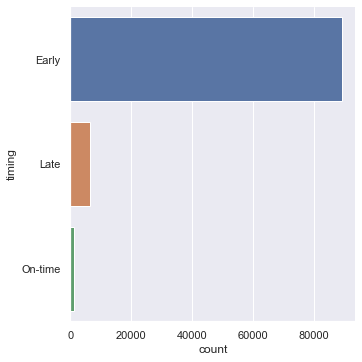

In [83]:
print(orders['timing'].value_counts())
sb.catplot(y = "timing", data = orders, kind = "count")

Therefore, we can see 3 categories of orders. Orders that are late, early, and on-time. Lets investigate how the customer sentiment differs for each of the categories.

In [84]:
mf_df = order_status_df.merge(mf_df,on='order_id', how='left')
mf_df = orders.merge(mf_df,on='order_id', how='left')
mf_df = mf_df[mf_df.sentiment.notnull()]

In [85]:
mf_df['timing']

0        Early
1        Early
3        Early
9        Early
13       Early
         ...  
97003    Early
97004     Late
97009    Early
97010    Early
97011    Early
Name: timing, Length: 36163, dtype: object

<AxesSubplot:>

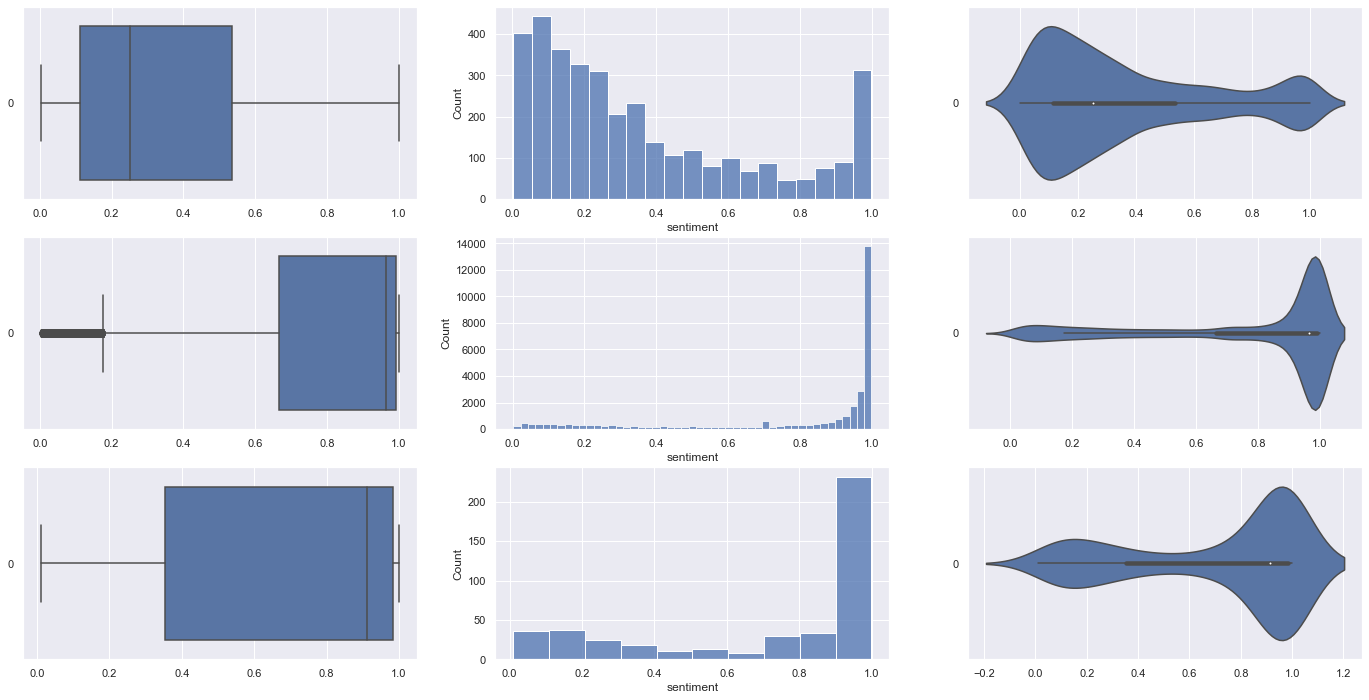

In [87]:
late_orders = mf_df.loc[mf_df["timing"] == "Late"]
ideal_orders = mf_df.loc[mf_df["timing"]=="On-time"]
early_orders = mf_df.loc[mf_df["timing"]=="Early"]

late_orders = late_orders.reset_index(drop=True)
early_orders = early_orders.reset_index(drop=True)
ideal_orders = ideal_orders.reset_index(drop=True)

# Lets perform univariate statistics on the late_sent, early_sent, ideal_sent
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(3, 3, figsize=(24, 12))

# Plot the basic uni-variate figures for late_sent
sb.boxplot(data = late_orders['sentiment'], orient = "h", ax = axes[0,0])
sb.histplot(data = late_orders['sentiment'], ax = axes[0,1])
sb.violinplot(data = late_orders['sentiment'], orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for late_sent
sb.boxplot(data = early_orders['sentiment'], orient = "h", ax = axes[1,0])
sb.histplot(data = early_orders['sentiment'], ax = axes[1,1])
sb.violinplot(data = early_orders['sentiment'], orient = "h", ax = axes[1,2])

#Plot the basic uni-variate figures for ideaal_sent
sb.boxplot(data = ideal_orders['sentiment'], orient = "h", ax = axes[2,0])
sb.histplot(data = ideal_orders['sentiment'], ax = axes[2,1])
sb.violinplot(data = ideal_orders['sentiment'], orient = "h", ax = axes[2,2])


---

# Explatory Analysis (2):

Our goal now is to further rank the top 5 companies.

First, we shall see is growth prediction is feasiable.
We shall attempt to do so with the following predictors in mind:
* Sales
* Revenue

Let's start by picking the company with highest sentiment value from the dataframe we filtered 

### Feasibility of Growth Prediction

#### Data Preperation

In [88]:
#Filter dataset to a single company
comp_trans_hist = pd.DataFrame({
    'Date':[],
})

mf_df = mf_df.sort_values(by='order_purchase_timestamp')
mf_df_tranc = mf_df[mf_df['seller_id'] == sellers.iloc[1].name]

#Store date as index
count = 0
for index, row in mf_df_tranc.iterrows():        
    comp_trans_hist.loc[count] = row['order_purchase_timestamp'].split()[0]
    count+=1;
    
comp_trans_hist.describe()
comp_trans_hist = comp_trans_hist.drop_duplicates()
comp_trans_hist.set_index('Date',inplace=True)

#### Exploration

In [89]:
#Compute daily sale and revenue and store in comp_trans_hist dataframe
comp_trans_hist['sale'] = 0
comp_trans_hist['revenue'] = 0

for index, row in mf_df_tranc.iterrows(): 
    try:
        comp_trans_hist.loc[row['order_purchase_timestamp'].split()[0],'sale'] = comp_trans_hist.loc[row['order_purchase_timestamp'].split()[0],'sale'] + 1
        comp_trans_hist.loc[row['order_purchase_timestamp'].split()[0],'revenue'] = comp_trans_hist.loc[row['order_purchase_timestamp'].split()[0],'sale'] + row['price']
    except:
        pass

    
#Reset index and revert to previous date column format
comp_trans_hist = comp_trans_hist.reset_index()

#Generate Monthly Sales and Revenue
comp_trans_hist.Date = pd.to_datetime(comp_trans_hist.Date)
comp_trans_hist =  comp_trans_hist.resample('M', on='Date').sum()   


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

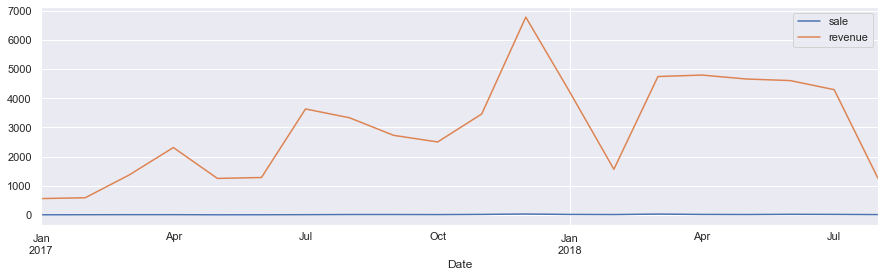

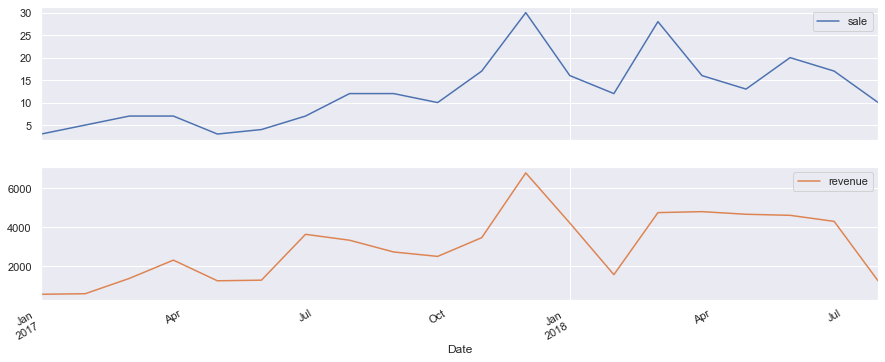

In [90]:
comp_trans_hist.plot(figsize=(15,4))
comp_trans_hist.plot(subplots=True, figsize=(15,6))

Observations:
* Overall non-linear revenue and sasles
* Information given is less than half a year
* There might not be enough information to get a accurate prediction of the growth of the company

Perhaps, linear regression growth prediction with only sale and revenue is not feasiable.

### Feasibility of Customer Lifetime Value

Now, lets try to predict customer lifetime value(CLV) instead.

In [91]:
#Filter dataset to a single company
customer_hist = pd.DataFrame({
    'Customer ID':[],
    'Trans Date':[]
})

mf_df = mf_df.sort_values(by='order_purchase_timestamp')
mf_df = mf_df.drop_duplicates(['order_id'])
mf_df_tranc = mf_df[mf_df['seller_id'] == sellers.iloc[0].name]

#Store date as index
count = 0
for index, row in mf_df_tranc.iterrows():            
    customer_hist.loc[count] = [row['customer_unique_id'],row['order_purchase_timestamp']]
    count+=1;
    
customer_hist = customer_hist[customer_hist.duplicated(subset=['Customer ID'],keep=False)]

print(customer_hist)

                          Customer ID           Trans Date
15   d8a89dc47bde7dc0b83a3434cc017ee1  2017-03-10 08:10:58
265  d8a89dc47bde7dc0b83a3434cc017ee1  2017-11-06 21:40:01


Observations:
* Too few reoccuring customers to predict CLV

---

# References

[1] Olist. (2019). Brazilian E-Commerce Public Dataset by Olist. Retrieved April 1, 2021, from https://www.kaggle.com/olistbr/brazilian-ecommerce.


[2] Mauro, D. P. (2020, July 16). Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT. Retrieved Feburary 25, 2021, from https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794


[3] Scikit-learn: Machine Learning. (n.d.). Scikit-learn User Guide, Naive Bayes. Retrieved Feburary 29, 2021, from https://scikit-learn.org/stable/modules/naive_bayes.html


[4] Scikit-learn: Machine Learning. (n.d.). Scikit-learn User Guide, Precision-Recall. Retrieved Feburary 29, 2021, from https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html


[5] Scikit-learn: Machine Learning. (n.d.). API Reference, RandomForestClassifier. Retrieved Feburary 29, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


[6] Scikit-learn: Machine Learning. (n.d.). API Reference, DecisionTreeClassifier. Retrieved Feburary 29, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


[7] Scikit-learn: Machine Learning. (n.d.). Scikit-learn User Guide, Feature extraction. Retrieved from Feburary 29, 2021, from https://scikit-learn.org/stable/modules/feature_extraction.html


[8] NTLK. (n.d.). HOWTO, Examples for Portuguese Processing. Retrieved from April 12, 2021, from http://www.nltk.org/howto/portuguese_en.html


[9] AFAF5. (2021, January 11). Textblob vs Vader for sentiment analysis in Python. Retrieved April 14, 2021, from https://www.analyticsvidhya.com/blog/2021/01/sentiment-analysis-vader-or-textblob/


[10] Genediazjr. (n.d.). stopwords-pt. Retrieved from April 12,2021, from https://github.com/stopwords-iso/stopwords-pt


[11] TextBlob. (n.d.). Simplified Text Processing. Retrieved April 17, 2021, from https://textblob.readthedocs.io/en/dev/


[12] Scikit-learn. (n.d.). Scikit-learn User Guide, Receiver Operating Characteristic. Retrieved April 19, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
